<H1> Notebook to verify the calculations of our simulator </H1>

## Importing required libraries

In [1]:
# importaing standard libraries
import zipfile
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import freqs,periodogram,cheby1
import numpy as np

In [2]:
# import quantum libraries
import qutip

from qmldataset import run_default_experiment

2021-09-13 18:46:57.782632: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Create a set of data
The package uses numerical libraries to simulate the quantum system, the control and noise signals (of predefined types). By default, the `1-qubit` and `2-qubit` experiments supported are
    - '1q_X'
    - '1q_X_N1Z'
    - '1q_X_N2Z'
    - '1q_X_N3Z'
    - '1q_X_N4Z'
    - '1q_XY'
    - '1q_XY_N1X_N5Z'
    - '1q_XY_N1X_N6Z'
    - '1q_XY_N3X_N6Z'
    - '2q_IX_XI_XX'
    - '2q_IX_XI_XX_N1N5IZ_N1N5ZI'
    - '2q_IX_XI_XX_N1N6IZ_N1N6ZI'
    - '2q_IX_XI_N1N6IZ_N1N6ZI'


For each of the experiments, we can also use either `"Gaussian"` or `"Square"` pulse shapes.

Each experiment will create 2 zip files containing the result of the experiment.

For example, the experiment `1q_X_N4Z` with `Square` pulse shape will create the following file:

`S_1q_X_N4Z.zip`
`S_1q_X_N4Z_distortion.zip`

In this notebook, we will create a 1-qubit experiment 

In [3]:
experiment = '1q_X_N4Z'

num_examples = 100 # other options, 10000
batch_size = 5     # other options, 50
output_location = "/home/rchakrav/progs/qmldataset_result/"
pulse_shape = "Square"

run_default_experiment(
    experiment_config=experiment,
    pulse_shape=pulse_shape,
    num_examples=num_examples,
    batch_size=batch_size,
    output_location=output_location
)

## Once saved, let us read the experiment outcome

In [4]:
# verification parameters
dataset = "/home/rchakrav/progs/qmldataset_result/S_1q_X_N4Z_distortion.zip"
ex_num  = 1

In [5]:
fname = "home/rchakrav/progs/qmldataset_result/1q_X_N4Z_ex_0"

# unzip the dataset zipfile and extract the example file
fzip  = zipfile.ZipFile(dataset, mode='r')
fzip.extract( fname )
fzip.close()

# load the example file
f     = open(fname,  "rb")
data  = pickle.load(f)
f.close()
os.remove(fname)

[[[-41.590927     0.10665751   0.1       ]
  [-35.76586      0.2765672    0.1       ]
  [ 39.64622      0.444211     0.1       ]
  [ 94.93673      0.5956799    0.1       ]
  [ 62.853886     0.76653636   0.1       ]]]


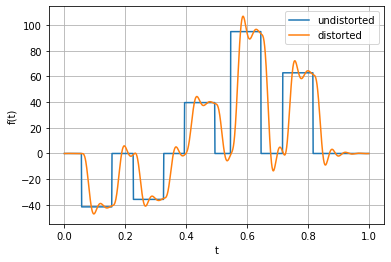

In [6]:
# plot the pulse
plt.figure()
num_controls = len(data["sim_parameters"]["dynamic_operators"])
for idx in range(num_controls):
    plt.subplot(num_controls , 1, idx+1 )
    plt.plot(data["time_range"], data["pulses"][0,:,0,idx], label="undistorted")
    plt.plot(data["time_range"], data["distorted_pulses"][0,:,0,idx], label="distorted")
    plt.xlabel('t')
    plt.ylabel('f(t)')
    plt.grid()
    plt.legend()
print(data["pulse_parameters"])

## Display the distortion if exists

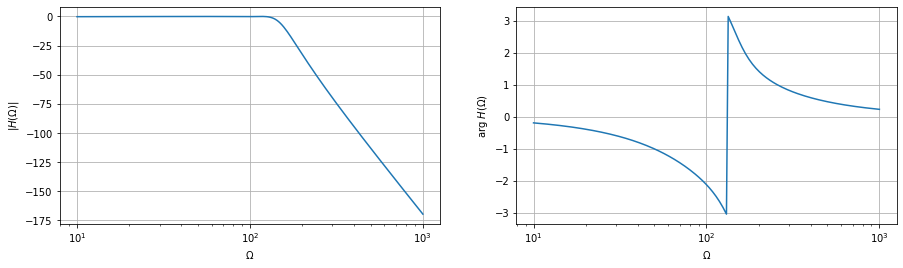

In [7]:
# display distortion filter if exists
distortion = cheby1(4,0.1,2*np.pi*20, analog=True)
# evaluate frequency response of the filter
w, Hw = freqs(distortion[0], distortion[1])
plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
plt.semilogx(w, 20*np.log(np.abs(Hw)))
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$|H(\Omega)|$')
plt.grid()
plt.subplot(1,2,2)
plt.semilogx(w, np.angle(Hw))
plt.xlabel(r'$\Omega$')
plt.ylabel(r'arg $H(\Omega)$')
plt.grid()

## Display the noise

In [8]:
# display noise if exists
for idx_profile,profile in enumerate(data["sim_parameters"]["noise_profile"]): 
    if profile in [2,3,4] or (profile==6 and p==0): 
        # estimate the correlation matrix of the noise
        correlation = 0
        for k in range(data["sim_parameters"]["num_realizations"]):
            correlation = correlation + data["noise"][0,:,k:k+1,idx_profile]@data["noise"][0,:,k:k+1,idx_profile].T
        correlation = correlation/data["sim_parameters"]["num_realizations"]
        # plot correlation matrix
        plt.figure()
        plt.matshow(correlation,0)
        plt.colorbar()
        p = 0
    elif profile in [1,5]:
        # estimate the PSD of the noise
        psd = 0
        for k in range(data["sim_parameters"]["num_realizations"]):
            f, Pxx = periodogram(data["noise"][0,:,k,idx_profile], data["sim_parameters"]["num_time_steps"]/data["sim_parameters"]["evolution_time"])            
            psd = psd + Pxx
        psd = psd/data["sim_parameters"]["num_realizations"]
        plt.figure()
        plt.plot(f[f>0], psd[1:])
        plt.xlabel('f')
        plt.ylabel('psd')
        plt.grid()
        p = 1

In [11]:
# load initial states, measurement operators, and control Hamilotonian
initial_states = [qutip.Qobj(state) for state in data["sim_parameters"]["initial_states"] ] 
measurements   = [qutip.Qobj(op) for op in data["sim_parameters"]["measurement_operators"] ]

H0  = [ [qutip.Qobj(op), np.ones((len(data["sim_parameters"]["time_range"])))] for op in data["sim_parameters"]["static_operators"] ] + [ [qutip.Qobj(op), data["distorted_pulses"][0,:,0,idx]] for idx, op in enumerate(data["sim_parameters"]["dynamic_operators"]) ]

expectations = np.zeros((1,data["sim_parameters"]["num_realizations"], len(initial_states)*len(measurements)))  
for idx_K in range(data["sim_parameters"]["num_realizations"]):    
    H1      = [ [qutip.Qobj(op), data["noise"][0,:,idx_K,idx]] for idx, op in enumerate(data["sim_parameters"]["noise_operators"]) ]
    results = [ qutip.mesolve(H0 + H1, rho, np.array(data["sim_parameters"]["time_range"]), e_ops=measurements).expect for rho in initial_states]     
    expectations [0,idx_K, :] = np.concatenate( [np.array( [results[idx_rho][idx_M][-1] for idx_M in range(len(measurements))]) for idx_rho in range(len(initial_states))])
    print(idx_K+1,  end="\r")

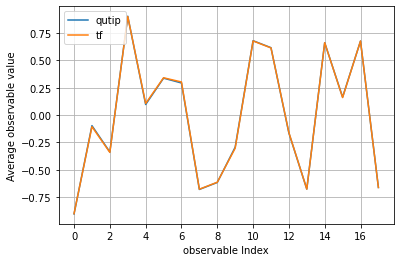

In [12]:
# plot the average expectation over all noise realizations for every observable
plt.figure()
plt.plot(np.average(expectations, 1)[0], label="qutip")
plt.plot(data["expectations"][0], label = "tf")
plt.ylabel("Average observable value")
plt.xlabel("observable Index")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend()
plt.grid()

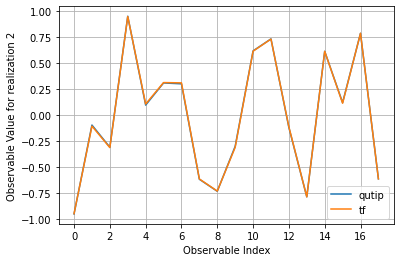

In [13]:
# plot all possible observables for a particular noise realization
idx_K = 2
plt.figure()
plt.plot(expectations[0,idx_K,:], label="qutip")
plt.plot(data["Eo"][0,idx_K,:],  label = "tf")
plt.ylabel("Observable Value for realization %d"%idx_K)
plt.xlabel("Observable Index")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend()
plt.grid()